In [12]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *
from quimb import *
import numpy as np
import random
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt

In [13]:
def random_2q_unitary():
    # generate random 2-qubit unitary
    return qu.rand_uni(4)
def ipr(state):
    # calculate IPR, takes statevector
    state = state / np.linalg.norm(state)
    return np.sum(np.abs(state) ** 4)
def pentropy(ipr):
    # calculate participation entropy from IPR
    return -np.log(ipr)

In [14]:
# define Z-basis projectors to use in measurements
P0 = np.array([[1, 0],[0, 0]], dtype=complex)
P1 = np.array([[0, 0],[0, 1]], dtype=complex)

def z_measure(circ, L, p, rng, round_int):
    # Measure each qubit in Z-basis with prob p using marginals, then collapse with projectors.
    outcomes = [None] * L #initalize list of measurement outcomes
    for j in range(L):
        # for each qubit, continue without measuring if random number [0,1] >= p, measure if < p
        if rng.random() >= p:
            continue

        # unnormalized weights, sum equals current ||psi||^2
        pm = np.asarray(circ.compute_marginal((j,)), dtype=float)
        totalprob = pm.sum()  # current ||psi||^2
        if totalprob <= 0:
            continue
        pm /= totalprob  # normalize to use as Born probabilities

        m = 0 if rng.random() < pm[0] else 1
        outcomes[j] = m
        # DEBUGGING
        # print(f"r:{round_int}, qubit:{j}, pm:{pm}, total prob:{totalprob}, norm:{circ.psi.norm()}")  # debugging
        # print(pm.sum())
        # scale by 1/sqrt(raw outcome weight) so new state has norm ~ 1
        raw_outcome_weight = max(totalprob * (pm[0] if m == 0 else pm[1]), np.finfo(float).tiny)
        scale = 1.0 / np.sqrt(raw_outcome_weight)
        proj = (P0 if m == 0 else P1) * scale

        circ.apply_gate(
            proj,
            j,
            gate_round=round_int,
            tags=("MEAS", f"MEAS_round{round_int}", f"MEAS_q{j}")
        )

    # normalize again to be safe at end (should already be ~1)
    try:
        circ.psi.normalize_()
    except AttributeError:
        nrm = float(abs(circ.psi.norm()))
        if nrm > 0:
            circ.psi.multiply_(1.0 / nrm)

    return outcomes


prob: 0
run:
0
1
2
3
4
5
6
7
8
9
prob: 0.1
run:
0
1
2
3
4
5
6
7
8
9
prob: 0.15
run:
0
1
2
3
4
5
6
7
8
9
prob: 0.18
run:
0
1
2
3
4
5
6
7
8
9
prob: 0.2
run:
0
1
2
3
4
5
6
7
8
9


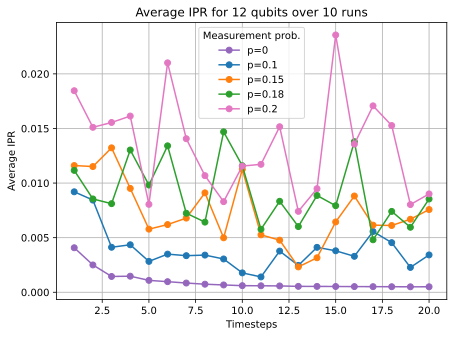

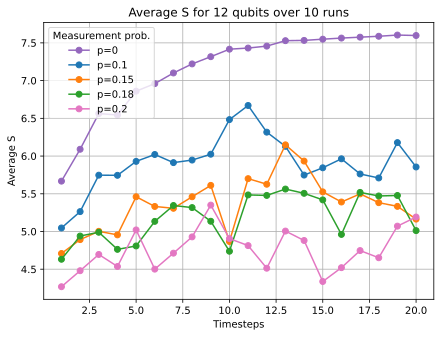

Circuit for p= 0.2


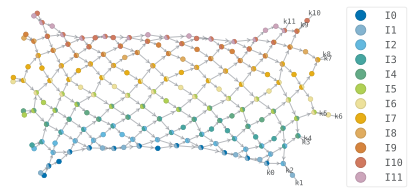

Qubits measured in circuit for p= 0.2


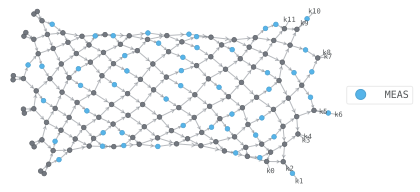

In [15]:
# PARAMETERS
L = 12               # number of qubits
D = 20               # number of layers
n_runs = 10          # number of independent circuit realizations to average over, this param scales worst
p_values = [0, 0.1, 0.15, 0.18, 0.2]  # measurement probability per qubit per layer, will compare all probs in list
colors = ['tab:purple', 'tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:red'] # make sure you have at least enough colors for each probability
rng = np.random.default_rng(None) # random float in [0, 1), replace None with seed (1234) for reproducability

iprs_avg_dict = {} # to store averaged IPRs for each prob since they get overwritten in loop
entropies_avg_dict = {} # "" for entropies
circuits = {} # save circuits to draw


#plt.figure(figsize=(7, 5)) # start fig

for p, color in zip(p_values, colors): # loop over measurement probs
    iprs_avg = np.zeros(D + 1) # initialize IPRs for 0th + D layers
    entropies_avg = np.zeros(D + 1)
    print('prob:', p)
    print('run:')
    for run in range(n_runs): # loop over n runs
        print(run) # I use this as a progress bar
        circ = qtn.Circuit(N=L) #initialize circuit of length L at start of each run, default all in 0
        iprs = [] # to store ipr at each layer
        entropies = [] # to store each participation entropy
        psi0 = circ.psi.to_dense() # initial state; circ is circuit, psi is tensor network state, to_dense gives single statevector (note this is expensive)
        ipr0 = ipr(psi0) # should be 1
        iprs.append(ipr0)
        entropies.append(pentropy(ipr0)) 

        for r in range(D): # for each layer in depth
            if r % 2 == 0: 
                # at even layers apply random 2-site unitary
                for i in range(0, L - 1, 2):
                    U = random_2q_unitary()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (0,1), (2,3), ...
            else:
                for i in range(1, L - 1, 2):
                # at odd layers apply random unitary
                    U = random_2q_unitary()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (1,2), (3,4), ...

            outcomes = z_measure(circ, L, p, rng, round_int=r) #after each layer, measure with prob p

            psi = circ.psi.to_dense()
            ipr_n=ipr(psi)
            iprs.append(ipr_n) # record IPR after each layer and measurement
            entropies.append(pentropy(ipr_n))

        iprs_avg += np.array(iprs) # summing IPR at each layer for each run
        entropies_avg += np.array(entropies)

    iprs_avg /= n_runs # average the array of IPRs over runs
    iprs_avg_dict[p] = iprs_avg  # store avg IPRs with corresponding probability to plot
    entropies_avg /= n_runs
    entropies_avg_dict[p] = entropies_avg
    circuits[p] = circ

    #xi = range(1, D + 1)
    #yi = iprs_avg[1:]
    #plt.plot(xi, yi, marker='o', color=color, label=f"p={p}")
    # plt.plot(range(1, D + 1), iprs_avg, marker='o', color=color, label=f"p={p}") # you will get an error here if not enough colors in your list
    # n_meas = sum(1 for t in circ.psi if "MEAS" in t.tags)
    #print("MEAS tensors:", n_meas, " expected:", L * D)

    #xs = range(1, D + 1)
    #ys = entropies_avg[1:]
    #plt.plot(xs, ys, marker='o', color=color, label=f"p={p}")
    # plt.plot(range(1, D + 1), iprs_avg, marker='o', color=color, label=f"p={p}") # you will get an error here if not enough colors in your list


# Plot IPR
plt.figure(figsize=(7, 5))
for p, color in zip(p_values, colors):
    xi = range(1, D + 1)
    yi = iprs_avg_dict[p][1:]  # skip t=0
    plt.plot(xi, yi, marker='o', color=color, label=f"p={p}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average IPR")
plt.title(f"Average IPR for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="Measurement prob.")
plt.show()

# Plot S
plt.figure(figsize=(7, 5))
for p, color in zip(p_values, colors):
    xs = range(1, D + 1)
    ys = entropies_avg_dict[p][1:]  # skip t=0
    plt.plot(xs, ys, marker='o', color=color, label=f"p={p}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average S")
plt.title(f"Average S for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="Measurement prob.")
plt.show()

# Draw circuit and qubits measured for last p
print('Circuit for p=', p)
circ.psi.draw(color=[f'I{i}' for i in range(L)], show_tags=False)
print('Qubits measured in circuit for p=', p)
circ.psi.draw(color=["MEAS"], show_tags=False) 


Circuit for p=0


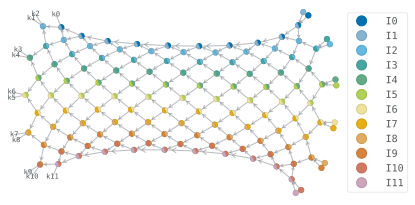

Qubits measured in circuit for p=0


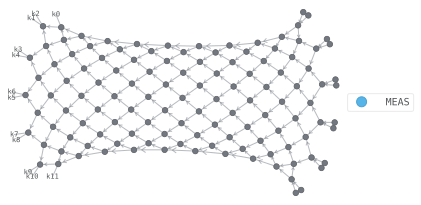

Circuit for p=0.1


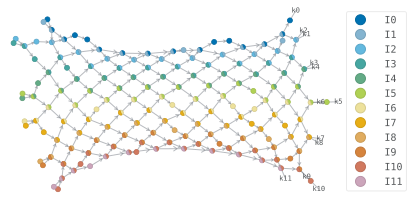

Qubits measured in circuit for p=0.1


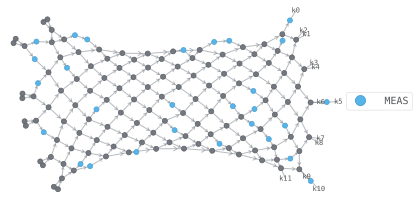

Circuit for p=0.15


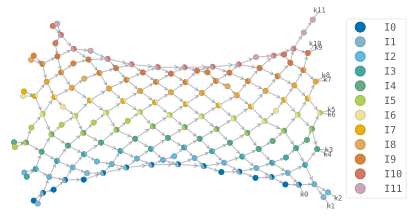

Qubits measured in circuit for p=0.15


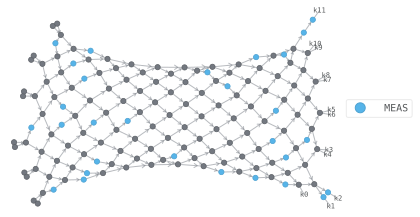

Circuit for p=0.18


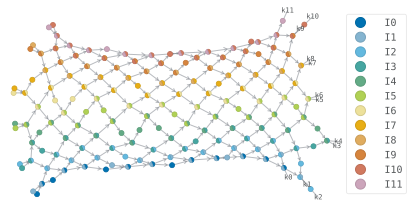

Qubits measured in circuit for p=0.18


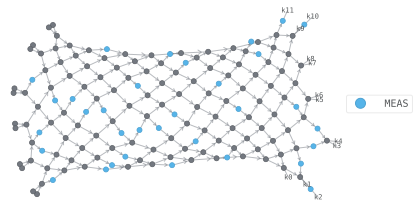

Circuit for p=0.2


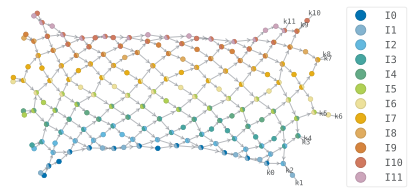

Qubits measured in circuit for p=0.2


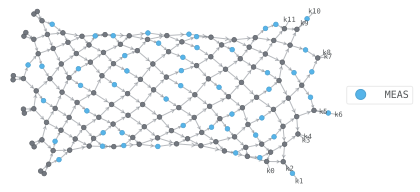

In [16]:
for p, circ in circuits.items():
    print(f'Circuit for p={p}')
    circ.psi.draw(color=[f'I{i}' for i in range(L)], show_tags=False)
    print(f'Qubits measured in circuit for p={p}')
    circ.psi.draw(color=["MEAS"], show_tags=False)

In [17]:
# print stats for each prob
N = 2 ** L # Hilbert space dimension
haar_avg_ipr = 2 / (N + 1) # Average IPR of a Haar-random state for reference

for p in p_values:
    iprs_avg = iprs_avg_dict[p]
    # start looking for min and avg IPR after 10 layers, picked this arbitrarily based on where plots start leveling out
    min_ipr = np.min(iprs_avg[11:])
    avg_ipr_after_t10 = np.mean(iprs_avg[11:])

    print(f"\nResults for p={p}:")
    print(f"  Minimum IPR (t > 10): {min_ipr:.6g}")
    print(f"  Average IPR (t > 10): {avg_ipr_after_t10:.6g}") # probably need much more depth for this to be useful
    print(f"  Haar average IPR for L={L}: {haar_avg_ipr:.6g}")


Results for p=0:
  Minimum IPR (t > 10): 0.000498903
  Average IPR (t > 10): 0.000531412
  Haar average IPR for L=12: 0.000488162

Results for p=0.1:
  Minimum IPR (t > 10): 0.00140322
  Average IPR (t > 10): 0.00346353
  Haar average IPR for L=12: 0.000488162

Results for p=0.15:
  Minimum IPR (t > 10): 0.00232106
  Average IPR (t > 10): 0.00572846
  Haar average IPR for L=12: 0.000488162

Results for p=0.18:
  Minimum IPR (t > 10): 0.00480544
  Average IPR (t > 10): 0.00774027
  Haar average IPR for L=12: 0.000488162

Results for p=0.2:
  Minimum IPR (t > 10): 0.00740877
  Average IPR (t > 10): 0.0130279
  Haar average IPR for L=12: 0.000488162


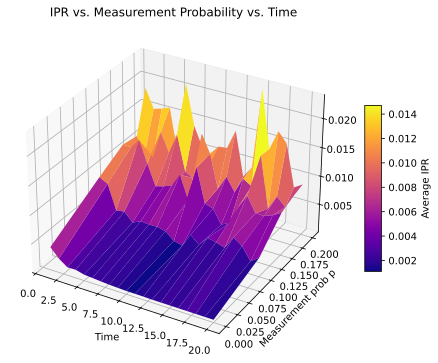

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# convert iprs_avg_dict into arrays for plotting
p_vals = sorted(iprs_avg_dict.keys())
times = np.arange(D + 1)
times = times[1:]  # skip t=0

# Create meshgrid
T, P = np.meshgrid(times, p_vals)

# Z array: each row is iprs for one p (skip first entry)
Z = np.array([iprs_avg_dict[p][1:] for p in p_vals])

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# plot the surface
surf = ax.plot_surface(
    T, P, Z,
    rstride=1, cstride=1,
    cmap='plasma',
    edgecolor='none',
    antialiased=True
)

ax.set_xlabel("Time")
ax.set_ylabel("Measurement prob p")
#ax.set_zlabel("Average IPR")
ax.set_title("IPR vs. Measurement Probability vs. Time")

fig.colorbar(surf, shrink=0.5, aspect=10, label="Average IPR")

plt.show()